# 1. 라이브러리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import time

from datetime import datetime

from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus
from xml.etree.ElementTree import parse
import json
import urllib
import requests
import xmltodict

import warnings
warnings.filterwarnings('ignore')

# 2. API 기본 형식

In [2]:
# API url
url = 'url 주소'

queryParams = '?' + urlencode({

                # 서비스키
                quote_plus('ServiceKey') : '서비스키',
                quote_plus('pageNo') : 'page',           # 페이지 설정
                quote_plus('numOfRows') : 'row',         # 페이지 당 조회 행 개수 설정
                quote_plus('dataType') : 'XML',          # datatype = xml
                quote_plus('dataCd') : 'ASOS',           # ASOS 관측 기구 조회
                quote_plus('dateCd') : 'day or hr',      # 시간 조회
                quote_plus('startDt') : 'start day',     # 시작 일자 설정
                quote_plus('endDt') : 'end day',         # 끝 일자 설정
                quote_plus('startHh') : 'start time',    # 시작 시간 설정
                quote_plus('endHh') : 'end time',        # 끝 시간 설정
                quote_plus('stnIds') : 'loc'})           # 지점번호 선택

# request 객체
request = urllib.request.Request(url + unquote(queryParams))

# url 응답 객체 저장
response_body = urlopen(request, timeout=60).read()

# 디코딩
decode_data = response_body.decode('utf-8')

# string인 xml 파싱
xml_parse = xmltodict.parse(decode_data)     
xml_dict = json.loads(json.dumps(xml_parse))

지상 기상 관측의 대표적인 방법은 종관기상관측(ASOS)와 방재기상관측(AWS)가 있습니다.

여러 지역에서 같은 시각에 관측하는 종관규모의 관측을 주로 기상데이터로 사용하기 때문에 본 프로젝트에서 종관기상관측(ASOS)를 이용합니다.

# 3. 지점 번호 선언

In [3]:
# API부를 때 필요한 지점 번호 리스트
std_list = [90, 93, 95, 98, 99, 100, 101, 102, 104, 105, 106, 108, 112, 114, 115, 119, 121, 127, 129, 130,
            131, 133, 135, 136, 137, 138, 140, 143, 146, 152, 155, 156, 159, 162, 165, 168, 169, 170, 172,
            174, 177, 184, 185, 188, 189, 192, 201, 202, 203, 211, 212, 216, 217, 221, 226, 232, 235, 236,
            238, 239, 243, 244, 245, 247, 248, 251, 252, 253, 254, 255, 257, 258, 259, 260, 261, 262, 263,
            264, 266, 268, 271, 272, 273, 276, 277, 278, 279, 281, 283, 284, 285, 288, 289, 294, 295]

# 4-1. 2011 ~ 2020년 일별 기후 데이터

In [4]:
# API url
url = 'http://apis.data.go.kr/1360000/AsosDalyInfoService/getWthrDataList'

# 데이터 프레임 컬럼 설정
col_list = ['지점_번호', '지점명', '시간', '평균_기온', '최저_기온', '최저_기온_시각', '최고_기온', '최고_기온_시각',
            '강수_계속시간', '10분_최다강수량', '10분_최다강수량_시각', '1시간_최다강수량', '1시간_최다_강수량_시각',
            '일강수량', '최대_순간풍속', '최대_순간_풍속_풍향', '최대_순간풍속_시각', '최대_풍속', '최대_풍속_풍향',
            '최대_풍속_시각', '평균_풍속', '풍정합', '최다_풍향', '평균_이슬점온도', '최소_상대습도', '평균_상대습도_시각',
            '평균_상대습도', '평균_증기압', '평균_현지기압', '최고_해면_기압', '최고_해면기압_시각', '최저_해면기압',
            '최저_해면기압_시각', '평균_해면기압', '가조시간', '합계_일조_시간', '1시간_최다_일사_시각', '1시간_최다_일사량',
            '합계_일사량', '일_최심신적설', '일_최심신적설_시각', '일_최심적설', '일_최심적설_시각', '합계_3시간_신적설',
            '평균_전운량', '평균_중하층운량', '평균_지면온도', '최저_초상온도', '평균_5cm_지중온도', '평균10cm_지중온도',
            '평균_20cm_지중온도', '평균_30cm_지중온도', '0.5m_지중온도', '1.0m_지중온도', '1.5m_지중온도', '3.0m_지중온도',
            '5.0m_지중온도', '합계_대형증발량', '합계_소형증발량', '9-9강수', '일기현상', '안개_계속_시간']

breaker = False
for std in std_list:
    df = pd.DataFrame()
    print(f'▷ 지점번호 {std} 시작 -- {datetime.now().time()}')
    
    if breaker == True:
        pass

    page = 1
    cnt = 0
    breaker = False

    # 네트워크 오류 발생으로 인한 누락 방지를 위해 try-except문으로 무한 루프로 구현
    while True:
        try:
            queryParams = '?' + urlencode({

                    # 서비스 키
                    quote_plus('serviceKey') : 'LlGn22WX8%2BUx36D9E%2FNkES4XSfhz7UTelVHghAms7Oxdee3fjCtplPkUpczGO%2Bc2BU%2BV%2Fh5Mh%2BWEEOk2h4yetQ%3D%3D',
                    quote_plus('pageNo') : f'{page}',      # 페이지 설정
                    quote_plus('numOfRows') : '366',       # 페이지 당 조회 행 개수 설정
                    quote_plus('dataType') : 'XML',        # datatype = xml
                    quote_plus('dataCd') : 'ASOS',         # ASOS 관측 기구 조회
                    quote_plus('dateCd') : 'DAY',          # 일자 조회
                    quote_plus('startDt') : f'20110101',   # 시작 일자 설정
                    quote_plus('endDt') : f'20201231',     # 끝 일자 설정
                    quote_plus('stnIds') : f'{std}'})      # 지점번호 선택

            # request 객체
            request = urllib.request.Request(url + unquote(queryParams))

            # url 응답 객체 저장
            response_body = urlopen(request, timeout=60).read()

            # 디코딩
            decode_data = response_body.decode('utf-8')

            # string인 xml 파싱
            xml_parse = xmltodict.parse(decode_data)   
            xml_dict = json.loads(json.dumps(xml_parse))
            result = xml_dict['response']['header']['resultMsg']

            # 무한 루프를 돌리기 때문에 try-except를 빠져나오지 못하는 'NO_DATA'오류일 경우 반복문을 빠져나오게 함
            if result == 'NO_DATA':
                break
            dicts = xml_dict['response']['body']['items']['item']

            df_temp = pd.DataFrame(columns = col_list)

            # 받은 데이터 데이터 프레임에 적재
            for j in range(len(dicts)):
                df_temp.loc[j] = dicts[j].values()

            df = pd.concat([df, df_temp])
            print(f'{page}page 완료', end=', ')
            page += 1
            cnt += 1
            if cnt == 12:
                breaker = True
                break

        except:
            print(f'{page}page 오류 다시 시작', end=', ')
            cnt += 1
            if cnt == 12:
                break

        # 한 페이지에 366개 row의 데이터가 들어가기 때문에 10페이지가 넘어가면 무한 루프 break
        if page == 11:
            break

    # 데이터 저장
    if len(df.values) != 0:
        df.to_csv(f"./dayday/{df['지점명'].unique()[0]}" + "_day_fianl.csv", index=False)
        print()
        print(f'지점번호 {std} 완료 -- {datetime.now().time()}\n')
    else:
        print(f'지점번호 {std} NO DATA\n')

훈련(train) 데이터로 사용할 2011 ~ 2020년 일별 데이터를 수집합니다.

# 4-2. 2021 ~ 2022년 일별 기후 데이터

In [5]:
# API url
url = 'http://apis.data.go.kr/1360000/AsosDalyInfoService/getWthrDataList'

# 데이터 프레임 컬럼 설정
col_list = ['지점_번호', '지점명', '시간', '평균_기온', '최저_기온', '최저_기온_시각', '최고_기온', '최고_기온_시각',
            '강수_계속시간', '10분_최다강수량', '10분_최다강수량_시각', '1시간_최다강수량', '1시간_최다_강수량_시각',
            '일강수량', '최대_순간풍속', '최대_순간_풍속_풍향', '최대_순간풍속_시각', '최대_풍속', '최대_풍속_풍향',
            '최대_풍속_시각', '평균_풍속', '풍정합', '최다_풍향', '평균_이슬점온도', '최소_상대습도', '평균_상대습도_시각',
            '평균_상대습도', '평균_증기압', '평균_현지기압', '최고_해면_기압', '최고_해면기압_시각', '최저_해면기압',
            '최저_해면기압_시각', '평균_해면기압', '가조시간', '합계_일조_시간', '1시간_최다_일사_시각', '1시간_최다_일사량',
            '합계_일사량', '일_최심신적설', '일_최심신적설_시각', '일_최심적설', '일_최심적설_시각', '합계_3시간_신적설',
            '평균_전운량', '평균_중하층운량', '평균_지면온도', '최저_초상온도', '평균_5cm_지중온도', '평균10cm_지중온도',
            '평균_20cm_지중온도', '평균_30cm_지중온도', '0.5m_지중온도', '1.0m_지중온도', '1.5m_지중온도', '3.0m_지중온도',
            '5.0m_지중온도', '합계_대형증발량', '합계_소형증발량', '9-9강수', '일기현상', '안개_계속_시간']

breaker = False
for std in std_list:
    df = pd.DataFrame()
    print(f'▷ 지점번호 {std} 시작 -- {datetime.now().time()}')
    
    if breaker == True:
        pass
    page = 1
    cnt = 0
    breaker = False

    # 네트워크 오류 발생으로 인한 누락 방지를 위해 try-except문으로 무한 루프로 구현
    while True:
        try:
            queryParams = '?' + urlencode({

                    # 서비스 키
                    quote_plus('serviceKey') : 'LlGn22WX8%2BUx36D9E%2FNkES4XSfhz7UTelVHghAms7Oxdee3fjCtplPkUpczGO%2Bc2BU%2BV%2Fh5Mh%2BWEEOk2h4yetQ%3D%3D',
                    quote_plus('pageNo') : f'{page}',     # 페이지 설정
                    quote_plus('numOfRows') : '366',      # 페이지 당 조회 행 개수 설정
                    quote_plus('dataType') : 'XML',       # datatype = xml
                    quote_plus('dataCd') : 'ASOS',        # ASOS 관측 기구 조회
                    quote_plus('dateCd') : 'DAY',         # 일자 조회
                    quote_plus('startDt') : f'20210101',  # 시작 일자 설정
                    quote_plus('endDt') : f'20221231',    # 끝 일자 설정
                    quote_plus('stnIds') : f'{std}'})     # 지점번호 선택

            # request 객체
            request = urllib.request.Request(url + unquote(queryParams))

            # url 응답 객체 저장
            response_body = urlopen(request, timeout=60).read()

            # 디코딩
            decode_data = response_body.decode('utf-8')

            # string인 xml 파싱
            xml_parse = xmltodict.parse(decode_data)    
            xml_dict = json.loads(json.dumps(xml_parse))
            result = xml_dict['response']['header']['resultMsg']

            # 무한 루프를 돌리기 때문에 try-except를 빠져나오지 못하는 'NO_DATA'오류일 경우 반복문을 빠져나오게 함
            if result == 'NO_DATA':
                # breaker = True
                break
            dicts = xml_dict['response']['body']['items']['item']

            df_temp = pd.DataFrame(columns = col_list)

            # 받은 데이터 데이터 프레임에 적재
            for j in range(len(dicts)):
                df_temp.loc[j] = dicts[j].values()

            df = pd.concat([df, df_temp])
            print(f'{page}page 완료', end=', ')
            page += 1
            cnt += 1
            if cnt == 6:
                breaker = True
                break

        except:
            print(f'{page}page 오류 다시 시작', end=', ')
            cnt += 1
            if cnt == 6:
                break

        # 한 페이지에 366개 row의 데이터가 들어가기 때문에 2페이지가 넘어가면 무한 루프 break
        if page == 3:
            break

    # 데이터 저장
    if len(df.values) != 0:
        df.to_csv(f"./data/data_day/test/{df['지점명'].unique()[0]}" + "_day_fianl.csv", index=False)
        print()
        print(f'지점번호 {std} 완료 -- {datetime.now().time()}\n')
    else:
        print(f'지점번호 {std} NO DATA\n')

테스트(test) 데이터로 사용할 2021 ~ 2022년 일별 데이터를 수집합니다.

# 4-3. 2011 ~ 2020년 시간별 기후 데이터

In [6]:
# API를 부르는 데에 걸리는 시간을 파악하기 위해 선언
from datetime import datetime

# API url
url = 'http://apis.data.go.kr/1360000/AsosHourlyInfoService/getWthrDataList'

for std in std_list:
    df = pd.DataFrame()
    print(f'▷ 지점번호 {std} 시작 -- {datetime.now().time()}')
    breaker = False
    for year in range(11, 21, 1):
        print(f'{year}년 시작', end = ', ')
        if breaker == True:
            break
        page = 1

        # 네트워크 오류 발생으로 인한 누락 방지를 위해 try-exept문으로 무한 루프로 구현
        while True:
            try:
                queryParams = '?' + urlencode({

                        # 서비스 키
                        quote_plus('ServiceKey') : '%2FNJpEb%2B4mPrdl%2BjK0N5XfHVW2zDqJiBAj7IwHykCI4aJExuDhIr9VfQeUYZKCAeIDNMRk%2BfUF0x9J47VhrxPyQ%3D%3D',
                        quote_plus('pageNo') : f'{page}',         # 페이지 설정
                        quote_plus('numOfRows') : '880',          # 페이지 당 조회 행 개수 설정
                        quote_plus('dataType') : 'XML',           # datatype = xml
                        quote_plus('dataCd') : 'ASOS',            # ASOS 관측 기구 조회
                        quote_plus('dateCd') : 'HR',              # 시간 조회
                        quote_plus('startDt') : f'20{year}0101',  # 시작 일자 설정
                        quote_plus('endDt') : f'20{year}1231',    # 끝 일자 설정
                        quote_plus('startHh') : '00',             # 시작 시간 설정
                        quote_plus('endHh') : '23',               # 끝 시간 설정
                        quote_plus('stnIds') : f'{std}'})         # 지점번호 선택

                # request 객체
                request = urllib.request.Request(url + unquote(queryParams))

                # url 응답 객체 저장
                response_body = urlopen(request, timeout=60).read()

                # 디코딩
                decode_data = response_body.decode('utf-8')

                # string인 xml 파싱
                xml_parse = xmltodict.parse(decode_data)     
                xml_dict = json.loads(json.dumps(xml_parse))
                result = xml_dict['response']['header']['resultMsg']

                # 무한 루프를 돌리기 때문에 try-exept 를 빠져나오지 못하는 'NO_DATA'오류일 경우 반복문을 빠져나오게 함
                if result == 'NO_DATA':
                    breaker = True
                    break
                dicts = xml_dict['response']['body']['items']['item']
                
                # 데이터 프레임 컬럼 설정
                df_temp = pd.DataFrame(columns = ['날짜', '시간', '지점_번호', '지점명', '기온', '강수량', '풍속', '풍향',
                                                  '습도','증기압', '이슬점온도', '현지기압', '해면기압', '일조', '일사', '적설',
                                                  '3시간_신절설', '전운량', '중하층운량', '운형', '최저운고', '시정', '지면온도',
                                                  '5cm_지중온도', '10cm_지중온도', '20cm_지중온도', '30cm_지중온도'])
                
                # 받은 데이터 데이터 프레임에 적재
                for i in range(len(dicts)):
                    df_temp.loc[i] = [dicts[i]['tm'][:10], dicts[i]['tm'][11:], dicts[i]['stnId'], dicts[i]['stnNm'],
                                      dicts[i]['ta'], dicts[i]['rn'], dicts[i]['ws'], dicts[i]['wd'], dicts[i]['hm'],
                                      dicts[i]['pv'], dicts[i]['td'], dicts[i]['pa'], dicts[i]['ps'], dicts[i]['ss'],
                                      dicts[i]['icsr'], dicts[i]['dsnw'], dicts[i]['hr3Fhsc'], dicts[i]['dc10Tca'],
                                      dicts[i]['dc10LmcsCa'], dicts[i]['clfmAbbrCd'], dicts[i]['lcsCh'], dicts[i]['vs'],
                                      dicts[i]['ts'], dicts[i]['m005Te'], dicts[i]['m01Te'], dicts[i]['m02Te'], dicts[i]['m03Te']]
                df = pd.concat([df, df_temp])
                print(f'{page}page 완료', end = ', ')
                page += 1

            except:
                print(f'{page}page 오류 다시 시작', end = ', ')
            if page == 11:
                break
        print()
        print(f'{year}년 완료 -- {datetime.now().time()}')
    
    # 지점 별로 csv 파일로 저장
    if len(df.values) != 0:
        df.to_csv(f"./data/data_hour/test/{df['지점명'].unique()[0]}" + "_tm_final.csv", index=False)
        print(f'지점번호 {std} 완료 -- {datetime.now().time()}\n')
    else:
        print(f'지점번호 {std} NO DATA\n')

시간별 데이터는 전처리 과정에서 일별 기후 데이터의 결측치를 대체하는 데 사용됩니다.

일별 학습(train) 데이터의 결측치를 대체하기 위해서 2011 ~ 2020년의 시간별 데이터를 수집합니다.

시간별 기후 데이터 수집 지표는 일별 데이터의 지표와 같습니다.

# 4-4. 2021 ~ 2022년 시간별 기후 데이터

In [7]:
# API를 부르는 데에 걸리는 시간을 파악하기 위해 선언
from datetime import datetime

# API url
url = 'http://apis.data.go.kr/1360000/AsosHourlyInfoService/getWthrDataList'

for std in std_list:
    df = pd.DataFrame()
    print(f'▷ 지점번호 {std} 시작 -- {datetime.now().time()}')
    breaker = False
    for year in range(21, 23, 1):
        print(f'{year}년 시작', end = ', ')
        if breaker == True:
            break
        page = 1

        # 네트워크 오류 발생으로 인한 누락 방지를 위해 try-exept문으로 무한 루프로 구현
        while True:
            try:
                queryParams = '?' + urlencode({

                        # 서비스 키
                        quote_plus('ServiceKey') : '%2FNJpEb%2B4mPrdl%2BjK0N5XfHVW2zDqJiBAj7IwHykCI4aJExuDhIr9VfQeUYZKCAeIDNMRk%2BfUF0x9J47VhrxPyQ%3D%3D',
                        quote_plus('pageNo') : f'{page}',         # 페이지 설정
                        quote_plus('numOfRows') : '880',          # 페이지 당 조회 행 개수 설정
                        quote_plus('dataType') : 'XML',           # datatype = xml
                        quote_plus('dataCd') : 'ASOS',            # ASOS 관측 기구 조회
                        quote_plus('dateCd') : 'HR',              # 시간 조회
                        quote_plus('startDt') : f'20{year}0101',  # 시작 일자 설정
                        quote_plus('endDt') : f'20{year}1231',    # 끝 일자 설정
                        quote_plus('startHh') : '00',             # 시작 시간 설정
                        quote_plus('endHh') : '23',               # 끝 시간 설정
                        quote_plus('stnIds') : f'{std}'})         # 지점번호 선택

                # request 객체
                request = urllib.request.Request(url + unquote(queryParams))

                # url 응답 객체 저장
                response_body = urlopen(request, timeout=60).read()

                # 디코딩
                decode_data = response_body.decode('utf-8')

                # string인 xml 파싱
                xml_parse = xmltodict.parse(decode_data)     
                xml_dict = json.loads(json.dumps(xml_parse))
                result = xml_dict['response']['header']['resultMsg']

                # 무한 루프를 돌리기 때문에 try-exept 를 빠져나오지 못하는 'NO_DATA'오류일 경우 반복문을 빠져나오게 함
                if result == 'NO_DATA':
                    breaker = True
                    break
                dicts = xml_dict['response']['body']['items']['item']
                
                # 데이터 프레임 컬럼 설정
                df_temp = pd.DataFrame(columns = ['날짜', '시간', '지점_번호', '지점명', '기온', '강수량', '풍속', '풍향',
                                                  '습도', '증기압', '이슬점온도', '현지기압', '해면기압', '일조', '일사', '적설',
                                                  '3시간_신절설', '전운량', '중하층운량', '운형', '최저운고', '시정', '지면온도',
                                                  '5cm_지중온도', '10cm_지중온도', '20cm_지중온도', '30cm_지중온도'])
                
                # 받은 데이터 데이터 프레임에 적재
                for i in range(len(dicts)):
                    df_temp.loc[i] = [dicts[i]['tm'][:10], dicts[i]['tm'][11:], dicts[i]['stnId'], dicts[i]['stnNm'],
                                      dicts[i]['ta'], dicts[i]['rn'], dicts[i]['ws'], dicts[i]['wd'], dicts[i]['hm'],
                                      dicts[i]['pv'], dicts[i]['td'], dicts[i]['pa'], dicts[i]['ps'], dicts[i]['ss'],
                                      dicts[i]['icsr'], dicts[i]['dsnw'], dicts[i]['hr3Fhsc'], dicts[i]['dc10Tca'],
                                      dicts[i]['dc10LmcsCa'], dicts[i]['clfmAbbrCd'], dicts[i]['lcsCh'], dicts[i]['vs'],
                                      dicts[i]['ts'], dicts[i]['m005Te'], dicts[i]['m01Te'], dicts[i]['m02Te'], dicts[i]['m03Te']]
                df = pd.concat([df, df_temp])
                print(f'{page}page 완료', end = ', ')
                page += 1

            except:
                print(f'{page}page 오류 다시 시작', end = ', ')
            if page == 11:
                break
        print()
        print(f'{year}년 완료 -- {datetime.now().time()}')

    # 지점 별로 csv 파일로 저장
    if len(df.values) != 0:
        df.to_csv(f"./data/data_hour/test/{df['지점명'].unique()[0]}" + "_tm_final.csv", index=False)
        print(f'지점번호 {std} 완료 -- {datetime.now().time()}\n')
    else:
        print(f'지점번호 {std} NO DATA\n')

일별 테스트(test) 데이터의 결측치를 대체하기 위해서 2021 ~ 2022년의 시간별 데이터를 수집합니다.

In [8]:
url = 'http://apis.data.go.kr/1360000/AsosHourlyInfoService/getWthrDataList'

std_list = [90, 93, 95, 98, 99, 100, 101, 102, 104, 105, 106, 108, 112, 114, 115, 119, 121, 127, 129, 130,
            131, 133, 135, 136, 137, 138, 140, 143, 146, 152, 155, 156, 159, 162, 165, 168, 169, 170, 172,
            174, 177, 184, 185, 188, 189, 192, 201, 202, 203, 211, 212, 216, 217, 221, 226, 232, 235, 236,
            238, 239, 243, 244, 245, 247, 248, 251, 252, 253, 254, 255, 257, 258, 259, 260, 261, 262, 263,
            264, 266, 268, 271, 272, 273, 276, 277, 278, 279, 281, 283, 284, 285, 288, 289, 294, 295]

for std in std_list:
    df = pd.DataFrame()
    print(f'▷ 지점번호 {std} 시작 -- {datetime.now().time()}')
    breaker = False
    for year in range(21, 23, 1):
        print(f'{year}년 시작')
        if breaker == True:
            break
        page = 1
        # breaker = False

        while True:
            try:
                queryParams = '?' + urlencode({
                        quote_plus('ServiceKey') : '%2FNJpEb%2B4mPrdl%2BjK0N5XfHVW2zDqJiBAj7IwHykCI4aJExuDhIr9VfQeUYZKCAeIDNMRk%2BfUF0x9J47VhrxPyQ%3D%3D',
                        quote_plus('pageNo') : f'{page}',         # 1 ~ 10
                        quote_plus('numOfRows') : '880',          # 윤년 때문에 366으로 설정
                        quote_plus('dataType') : 'XML',
                        quote_plus('dataCd') : 'ASOS',
                        quote_plus('dateCd') : 'HR',
                        quote_plus('startDt') : f'20{year}0101',
                        quote_plus('endDt') : f'20{year}1231',
                        quote_plus('startHh') : '00',
                        quote_plus('endHh') : '23',
                        quote_plus('stnIds') : f'{std}'})

                request = urllib.request.Request(url + unquote(queryParams))

                response_body = urlopen(request, timeout=60).read()

                decode_data = response_body.decode('utf-8')

                xml_parse = xmltodict.parse(decode_data)         # string인 xml 파싱
                xml_dict = json.loads(json.dumps(xml_parse))
                result = xml_dict['response']['header']['resultMsg']
                if result == 'NO_DATA':
                    breaker = True
                    break

                dicts = xml_dict['response']['body']['items']['item']

                df_temp = pd.DataFrame(columns = ['날짜', '시간', '지점_번호', '지점명', '기온', '강수량', '풍속', '풍향',
                                                  '습도', '증기압', '이슬점온도', '현지기압', '해면기압', '일조', '일사', '적설',
                                                  '3시간_신절설', '전운량', '중하층운량', '운형', '최저운고', '시정', '지면온도',
                                                  '5cm_지중온도', '10cm_지중온도', '20cm_지중온도', '30cm_지중온도'])

                for i in range(len(dicts)):
                    df_temp.loc[i] = [dicts[i]['tm'][:10], dicts[i]['tm'][11:], dicts[i]['stnId'], dicts[i]['stnNm'],
                                      dicts[i]['ta'], dicts[i]['rn'], dicts[i]['ws'], dicts[i]['wd'], dicts[i]['hm'],
                                      dicts[i]['pv'], dicts[i]['td'], dicts[i]['pa'], dicts[i]['ps'], dicts[i]['ss'],
                                      dicts[i]['icsr'], dicts[i]['dsnw'], dicts[i]['hr3Fhsc'], dicts[i]['dc10Tca'],
                                      dicts[i]['dc10LmcsCa'], dicts[i]['clfmAbbrCd'], dicts[i]['lcsCh'], dicts[i]['vs'],
                                      dicts[i]['ts'], dicts[i]['m005Te'], dicts[i]['m01Te'], dicts[i]['m02Te'], dicts[i]['m03Te']]
                df = pd.concat([df, df_temp])
                print(f'{page}page 완료', end=', ')
                page += 1

            except:
                print(f'{page}page 오류 다시 시작', end=', ')
            if page == 3:
                break
        print()
        print(f'{year}년 완료 -- {datetime.now().time()}')
    
    if len(df.values) != 0:
        df.to_csv(f"./data/data_hour/test/{df['지점명'].unique()[0]}" + "_tm_fianl.csv", index=False)
        print(f'지점번호 {std} 완료 -- {datetime.now().time()}\n')
    else:
        print(f'지점번호 {std} NO DATA\n')

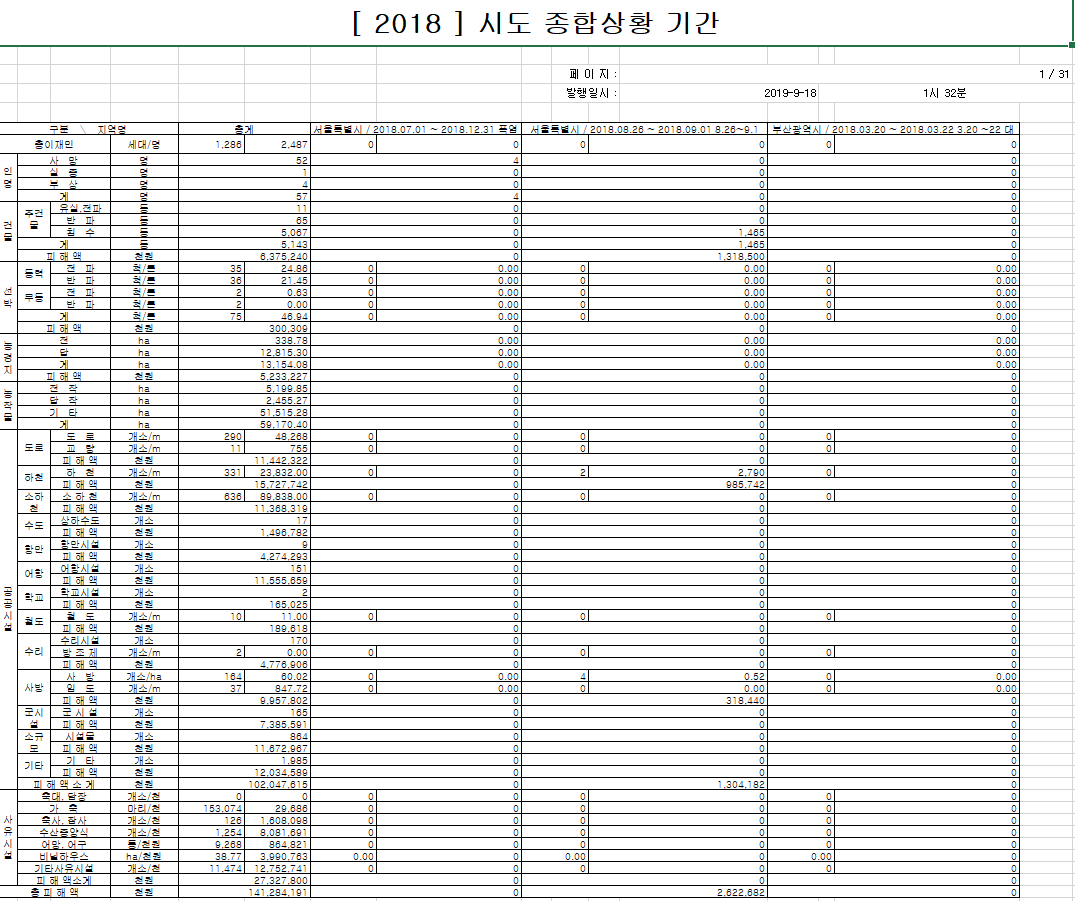

행정안전부의 복구지원과에서 매년 재해연보로 재해 데이터를 정리하는데, 피해규모에 대한 데이터는 국민재난안전포털에서 수집했습니다.